## Importing Data from Kaggle

In [ ]:
# Install kaggle package jika belum terinstall
!pip install kaggle

# Buat folder untuk API key Kaggle
!mkdir -p ~/.kaggle

# Upload API key Kaggle
# Simpan kaggle.json dengan API key Anda di path ini
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset dari Kaggle
!kaggle datasets download -d atulyakumar98/pothole-detection-dataset
!unzip pothole-detection-dataset.zip

import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

Dataset URL: https://www.kaggle.com/datasets/atulyakumar98/pothole-detection-dataset
License(s): CC0-1.0
 97% 188M/194M [00:01<00:00, 159MB/s]
100% 194M/194M [00:01<00:00, 152MB/s]
Archive:  pothole-detection-dataset.zip
  inflating: normal/1.jpg            
  inflating: normal/10.jpg           
  inflating: normal/100.jpg          
  inflating: normal/101.jpg          
  inflating: normal/102.jpg          
  inflating: normal/103.jpg          
  inflating: normal/104.jpg          
  inflating: normal/105.jpg          
  inflating: normal/106.jpg          
  inflating: normal/107.jpg          
  inflating: normal/108.jpg          
  inflating: normal/109.jpg          
  inflating: normal/11.jpg           
  inflating: normal/110.jpg          
  inflating: normal/111.jpg          
  inflating: normal/112.jpg          
  inflating: normal/113.jpg          
  inflating: normal/114.jpg          
  inflating: normal/115.jpg          
  inflating: normal/116.jpg          
  inflating: normal

## Data preprocessing

In [ ]:
def load_and_preprocess_image(image_path):
    # Load image and preprocess to grayscale, resize, and normalize
    img = Image.open(image_path).convert('L')
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = np.array(img).flatten() / 255.0
    return img_array

def load_dataset(normal_path, potholes_path):
    data = []
    labels = []

    # Load normal images
    for img_name in os.listdir(normal_path):
        img_path = os.path.join(normal_path, img_name)
        img_array = load_and_preprocess_image(img_path)
        data.append(img_array)
        labels.append(0)  # Label 0 for normal

    # Load pothole images
    for img_name in os.listdir(potholes_path):
        img_path = os.path.join(potholes_path, img_name)
        img_array = load_and_preprocess_image(img_path)
        data.append(img_array)
        labels.append(1)  # Label 1 for potholes

    return np.array(data), np.array(labels)

## Defining MLP Network

In [ ]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Constants
np.random.seed(42)
IMAGE_SIZE = 32
LEARNING_RATE = 0.005
EPOCHS = 1200

class SimpleMLP:
    def __init__(self, input_size, hidden_size, output_size):
        # Inisialisasi bobot dan bias
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, input_data):
        # Proses forward
        self.hidden_layer_input = np.dot(input_data, self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.sigmoid(self.hidden_layer_input)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        predictions = self.sigmoid(self.output_layer_input)
        return predictions

    def backward(self, input_data, labels, predictions):
        # Menghitung error
        error = labels.reshape(-1, 1) - predictions

        # Menghitung gradien untuk output layer
        d_output = error * self.sigmoid_derivative(predictions)
        # Menghitung gradien untuk hidden layer
        error_hidden_layer = d_output.dot(self.weights_hidden_output.T)
        d_hidden_layer = error_hidden_layer * self.sigmoid_derivative(self.hidden_layer_output)

        # Memperbarui bobot dan bias
        self.weights_hidden_output += self.hidden_layer_output.T.dot(d_output) * LEARNING_RATE
        self.bias_output += np.sum(d_output, axis=0, keepdims=True) * LEARNING_RATE
        self.weights_input_hidden += input_data.T.dot(d_hidden_layer) * LEARNING_RATE
        self.bias_hidden += np.sum(d_hidden_layer, axis=0, keepdims=True) * LEARNING_RATE

        # Compute Binary Cross-Entropy loss
        epsilon = 1e-8
        predictions_clipped = np.clip(predictions, epsilon, 1 - epsilon)
        loss = -np.mean(
            labels.reshape(-1, 1) * np.log(predictions_clipped) +
            (1 - labels.reshape(-1, 1)) * np.log(1 - predictions_clipped)
        )
        return loss

    def train(self, data, labels):
        for epoch in range(EPOCHS):
            # Proses forward dan backward
            predictions = self.forward(data)
            loss = self.backward(data, labels, predictions)

            # Hitung akurasi pada data training
            train_predictions = np.round(predictions)  # Membulatkan ke 0 atau 1
            accuracy = np.mean(train_predictions == labels.reshape(-1, 1))

            # Cetak loss dan akurasi setiap 100 epoch
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{EPOCHS}, Loss: {loss:.4f}, Training Accuracy: {accuracy * 100:.2f}%")


    def predict(self, input_image):
        prediction = self.forward(input_image)
        return "Pothole" if prediction >= 0.5 else "Normal"

## Creating function for save and load model


In [ ]:
from joblib import dump, load

# Fungsi untuk menyimpan model
def save_model(model, file_path):
    model_data = {
        'weights_input_hidden': model.weights_input_hidden,
        'bias_hidden': model.bias_hidden,
        'weights_hidden_output': model.weights_hidden_output,
        'bias_output': model.bias_output
    }
    dump(model_data, file_path)
    print(f"Model saved to {file_path}")

# Fungsi untuk memuat model
def load_model(model, file_path):
    model_data = load(file_path)
    model.weights_input_hidden = model_data['weights_input_hidden']
    model.bias_hidden = model_data['bias_hidden']
    model.weights_hidden_output = model_data['weights_hidden_output']
    model.bias_output = model_data['bias_output']
    print(f"Model loaded from {file_path}")



## Training Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
# Path to dataset
normal_path = 'normal'
potholes_path = 'potholes'

# Load data using stable train_test_split
data = np.load('train_test_split_data.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Load data
data, labels = load_dataset(normal_path, potholes_path)  # Memuat data
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)



# Initialize and train model
input_size = IMAGE_SIZE * IMAGE_SIZE
hidden_size = 64
output_size = 1

mlp = SimpleMLP(input_size, hidden_size, output_size)
mlp.train(X_train, y_train)  # Melatih model pada data training


Epoch 0/1200, Loss: 0.6944, Training Accuracy: 49.45%
Epoch 100/1200, Loss: 0.6158, Training Accuracy: 64.89%
Epoch 200/1200, Loss: 0.5857, Training Accuracy: 68.20%
Epoch 300/1200, Loss: 0.5645, Training Accuracy: 69.85%
Epoch 400/1200, Loss: 0.5434, Training Accuracy: 72.06%
Epoch 500/1200, Loss: 0.5129, Training Accuracy: 75.74%
Epoch 600/1200, Loss: 0.4817, Training Accuracy: 77.94%
Epoch 700/1200, Loss: 0.4567, Training Accuracy: 79.60%
Epoch 800/1200, Loss: 0.4358, Training Accuracy: 81.25%
Epoch 900/1200, Loss: 0.4164, Training Accuracy: 81.43%
Epoch 1000/1200, Loss: 0.3976, Training Accuracy: 82.54%
Epoch 1100/1200, Loss: 0.3791, Training Accuracy: 83.64%


## Model evaluation

Testing accuracy: 78.10%
Confusion Matrix:


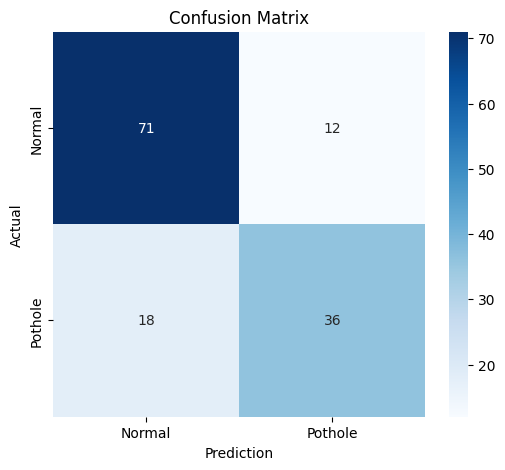

Precision: 0.7500
Recall: 0.6667
F1 Score: 0.7059


In [ ]:
# Evaluasi model pada data testing
predictions = np.round(mlp.forward(X_test))  # Lakukan prediksi pada data testing
accuracy = np.mean(predictions == y_test.reshape(-1, 1))
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Precision, Recall, F1-Score
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Cetak hasil evaluasi
print(f"Testing accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pothole'], yticklabels=['Normal', 'Pothole'])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [ ]:
# # Saving train test split result
# np.savez('train_test_split_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
# files.download('train_test_split_data.npz')

## Saving Model

In [ ]:
file_path = 'mlp_model_78.joblib'
save_model(mlp, file_path)

Model saved to mlp_model_78.joblib


In [ ]:
file_path = 'mlp_model_77.joblib'
mlp_loaded = SimpleMLP(input_size, hidden_size, output_size)
load_model(mlp_loaded, file_path)

Model loaded from mlp_model_77.joblib


## Inference

In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk praproses gambar tunggal
def preprocess_single_image(image_path):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))  # Resize to match input size
    img_array = np.array(img).flatten() / 255.0  # Flatten and normalize
    return img_array.reshape(1, -1)  # Reshape for a single sample input

# Fungsi prediksi untuk gambar tunggal
def predict_image(image_path, model):
    # Preprocess the image
    image_data = preprocess_single_image(image_path)

    # Run forward pass for inference
    prediction = model.forward(image_data)

    # Interpret the prediction
    prediction_label = "Pothole" if prediction >= 0.5 else "Normal"
    return prediction_label, prediction

# Fungsi untuk mengunggah gambar dan melakukan prediksi
def upload_and_predict_image(model):
    # Upload image
    uploaded = files.upload()

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]
    print(f"Image uploaded: {image_path}")

    # Display the uploaded image
    img = Image.open(image_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    # Predict the image label
    prediction_label, confidence_score = predict_image(image_path, model)
    print(f"Prediction: {prediction_label}")
    print(f"Confidence Score: {confidence_score}")


Saving jalan-normal-7.png to jalan-normal-7 (1).png
Image uploaded: jalan-normal-7 (1).png


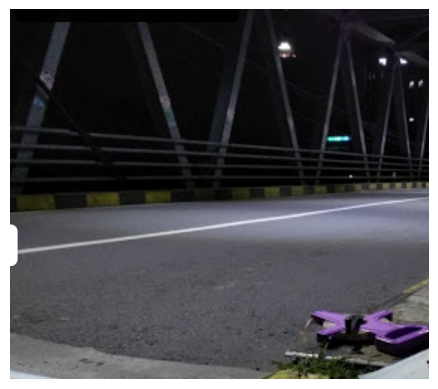

Prediction: Normal
Confidence Score: [[0.01706744]]


In [ ]:
# Inferensi
model = mlp  # Menggunakan model yang telah dilatih
upload_and_predict_image(model)


Saving jalan-lubang-5.png to jalan-lubang-5 (2).png
Image uploaded: jalan-lubang-5 (2).png


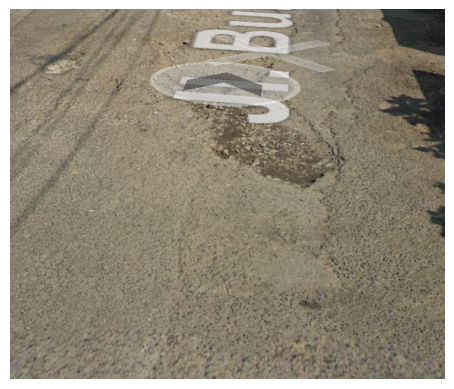

Prediction: Pothole
Confidence Score: [[0.6134128]]


In [ ]:
# Inferensi Pake load model
model = mlp_loaded  # Menggunakan model yang telah dilatih
upload_and_predict_image(model)


In [ ]:
import itertools

# Daftar nilai parameter yang ingin diuji
learning_rates = [0.005, 0.007]
epochs_list = [1000, 1200, 1300, 1500]
hidden_sizes = [64]

# Menyimpan hasil terbaik
best_accuracy = 0
best_params = {}

# Grid search untuk setiap kombinasi parameter
for learning_rate, epochs, hidden_size in itertools.product(learning_rates, epochs_list, hidden_sizes):
    print(f"Testing with Learning Rate: {learning_rate}, Epochs: {epochs}, Hidden Size: {hidden_size}")

    # Set learning rate dan epochs global
    LEARNING_RATE = learning_rate
    EPOCHS = epochs

    # Inisialisasi model dengan parameter saat ini
    mlp = SimpleMLP(input_size=IMAGE_SIZE * IMAGE_SIZE, hidden_size=hidden_size, output_size=1)

    # Latih model dengan parameter ini
    mlp.train(X_train, y_train)

    # Evaluasi model pada data testing
    predictions = np.round(mlp.forward(X_test))
    accuracy = np.mean(predictions == y_test.reshape(-1, 1))

    # Cetak hasil akurasi
    print(f"Testing accuracy with current params: {accuracy * 100:.2f}%\n")

    # Periksa apakah akurasi ini adalah yang terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            "learning_rate": learning_rate,
            "epochs": epochs,
            "hidden_size": hidden_size
        }

# Cetak hasil terbaik
print("Best Parameters Found:")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Epochs: {best_params['epochs']}")
print(f"Hidden Size: {best_params['hidden_size']}")
print(f"Best Testing Accuracy: {best_accuracy * 100:.2f}%")


Testing with Learning Rate: 0.005, Epochs: 1000, Hidden Size: 64
Epoch 0/1000, Loss: 0.6935, Training Accuracy: 49.45%
Epoch 100/1000, Loss: 0.6305, Training Accuracy: 61.76%
Epoch 200/1000, Loss: 0.5803, Training Accuracy: 69.49%
Epoch 300/1000, Loss: 0.5656, Training Accuracy: 70.22%
Epoch 400/1000, Loss: 0.5401, Training Accuracy: 73.35%
Epoch 500/1000, Loss: 0.5258, Training Accuracy: 73.53%
Epoch 600/1000, Loss: 0.4960, Training Accuracy: 76.65%
Epoch 700/1000, Loss: 0.4524, Training Accuracy: 80.33%
Epoch 800/1000, Loss: 0.4346, Training Accuracy: 81.07%
Epoch 900/1000, Loss: 0.4160, Training Accuracy: 81.99%
Testing accuracy with current params: 76.64%

Testing with Learning Rate: 0.005, Epochs: 1200, Hidden Size: 64
Epoch 0/1200, Loss: 0.6933, Training Accuracy: 49.45%
Epoch 100/1200, Loss: 0.6123, Training Accuracy: 65.62%
Epoch 200/1200, Loss: 0.5861, Training Accuracy: 68.01%
Epoch 300/1200, Loss: 0.5636, Training Accuracy: 70.22%
Epoch 400/1200, Loss: 0.5478, Training Accur